In [1]:
using LmaPredict, PyPlot
using Base.Iterators: partition
using Flux
using Flux.Optimise: update!
using Flux.Losses: logitbinarycrossentropy
using Statistics
using Random
using MLUtils


[ Info: Precompiling LmaPredict [4056ae44-f597-46f1-96e9-cdb3146ed00e]
┌ Warning: Package LmaPredict does not have ADerrors in its dependencies:
│ - If you have LmaPredict checked out for development and have
│   added ADerrors as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with LmaPredict
└ Loading ADerrors into LmaPredict from project dependency, future warnings for LmaPredict are suppressed.


In [2]:
path_plot="/Users/alessandroconigli/Desktop/postdoc-mainz/projects/MLtoLMA"
path_config = "/Users/alessandroconigli/Lattice/data/HVP/LMA/A654/"


"/Users/alessandroconigli/Lattice/data/HVP/LMA/A654/"

In [3]:
## Reading data 
fname = readdir(path_config)
idx_cut = findall(x->x<=2500, parse.(Int64, fname))
fname = fname[idx_cut]
idx = sortperm( parse.(Int64, fname))
fname = fname[idx]

cnfgarr = Vector{LMAConfig}(undef, 0)
for f in fname
    push!(cnfgarr, get_LMAConfig(joinpath(path_config, f), "g5-g5", em="PA", bc=false))
end


In [10]:
## data manipulation to stadard WHCN to feed model

NCNFG = length(cnfgarr)
TVALS = length(cnfgarr[1].data["rr"]["0"]) 

TSRC_rr = collect(keys(getfield(cnfgarr[1], :data)["rr"] ))
TSRC_re = collect(keys(getfield(cnfgarr[1], :data)["re"] ))
# the sources has to be the same for both rr and ee

rr_re_images = Vector{Array{Float64}}(undef, TVALS)

for t in 1:TVALS    

    rr_re_images[t] = Array{Float64}(undef, 2, 1, length(TSRC_rr), NCNFG)
    for n in 1:NCNFG
        for (k,ts) in enumerate(TSRC_rr)
            rr_aux = getfield(cnfgarr[n], :data)["rr"][ts][t]
            re_aux = getfield(cnfgarr[n], :data)["re"][ts][t]
            
            rr_re_images[t][:,:,k, n] = [rr_aux, re_aux] 
        end
    end
end

rr_re_images_train = Vector{Array{Float64}}(undef, TVALS)
rr_re_images_test = Vector{Array{Float64}}(undef, TVALS)

for t in 1:TVALS
    rr_re_images_train[t] = rr_re_images[t][:,:,:,1:5:end]
    diff_data = setdiff(rr_re_images[t], rr_re_images_train[t])
    rr_re_images_test[t]  = reshape(diff_data, (size(rr_re_images[t],1), size(rr_re_images[t],2), size(rr_re_images[t],3), size(rr_re_images[t],4)-size(rr_re_images_train[t],4))) 
end


In [11]:
## normalise data
using Statistics
min_val = Array{Float64}(undef, TVALS, length(TSRC_rr), 2 )
max_val = Array{Float64}(undef, TVALS, length(TSRC_rr), 2 )

std_val  = Array{Float64}(undef, TVALS, length(TSRC_rr), 2 )
mean_val = Array{Float64}(undef, TVALS, length(TSRC_rr), 2 )

for t in 1:TVALS
    for ts in 1:size(rr_re_images_train[t], 3)
        for k in 1:size(rr_re_images_train[t],1)
            minval = minimum(rr_re_images_train[t][k, 1, ts, :])
            maxval = maximum(rr_re_images_train[t][k, 1, ts, :])
            #rr_re_images_train[t][k, 1, ts, :] = normalise(rr_re_images_train[t][k, 1, ts, :])
            #rr_re_images_train[t][k, 1, ts, :] = (rr_re_images_train[t][k, 1, ts, :] .- minval) ./ (maxval - minval)
            mean_val[t, ts, k] = mean(rr_re_images_train[t][k,1,ts,:])
            std_val[t, ts, k] = std(rr_re_images_train[t][k,1,ts,:])
            rr_re_images_train[t][k, 1, ts, :] = normalise(rr_re_images_train[t][k,1,ts,:])
            #min_val[t, ts, k] = minval
            #max_val[t, ts, k] = maxval
        end
    end
end


In [13]:
# A vector for each TVALS
std(rr_re_images[40][1,1,2,:])
std_val;


In [ ]:
# batch dimensions
(rr_re_images[1][2,1,1,:]);

In [14]:
function discriminator()
    dscr = Chain(
        Dense(2 => 16, leakyrelu), # 2 => 16
        Dropout(0.3),
        Dense(16 => 8, leakyrelu), # 16 => 8  
        #BatchNorm(16, leakyrelu),
        #Dense(128=>64, leakyrelu),
        Dropout(0.3),
        Dense(8 => 1, sigmoid) # 8 => 1
    )
    return dscr
end

#dscr = discriminator()
#dscr(rr_re_images[1])

discriminator (generic function with 1 method)

In [15]:
function generator(latent_dim::Int)
    gen = Chain(
        Dense(latent_dim =>8),
        BatchNorm(8, relu),
        #x->reshape(x, 2, 1, 64,:),
        #Dense(64 => 128, leakyrelu), # this one is added
        Dense(8 => 16),
        BatchNorm(16, relu),
        Dense(16 => 2)
    )
    return gen
end

generator (generic function with 1 method)

In [16]:
function generate_noise(hparams)
    noise = randn(hparams.latent_dim,  hparams.batch_size)
    return noise
end

generate_noise (generic function with 1 method)

In [17]:
function generate_fake_sample(gen, hparams)
    noise = generate_noise(hparams)
    return gen(noise)
end

generate_fake_sample (generic function with 1 method)

In [18]:
# Loss functions
function discriminator_loss(real_sample, fake_sample)
    
    real_loss = logitbinarycrossentropy(real_sample, 1)
    fake_loss = logitbinarycrossentropy(fake_sample, 0)
    return real_loss + fake_loss
end

generator_loss(fake_sample) = logitbinarycrossentropy(fake_sample, 1)


generator_loss (generic function with 1 method)

In [19]:
function train_discriminator!(gen, dscr, real_sample, opt_discr, hparams)
    
    #noise = randn!(similar(real_sample, (hparams.latent_dim, hparams.batch_size)))
    #fake_sample = gen(noise)
    fake_sample = generate_fake_sample(gen, hparams) 
    
    loss, grad = Flux.withgradient(dscr) do dscr
        discriminator_loss(dscr(real_sample), dscr(fake_sample))
    end
    
    update!(opt_discr, dscr, grad[1])
    return loss
end

function train_generator!(gen, dscr, opt_gen, hparams)
    
    noise = generate_noise(hparams)
    
    loss, grad = Flux.withgradient(gen) do gen
        generator_loss(dscr(gen(noise)))
    end
    
    update!(opt_gen, gen, grad[1])
    return loss
end

train_generator! (generic function with 1 method)

In [21]:
# HyperParams
Base.@kwdef struct HyperParams
    batch_size::Int = 50
    latent_dim::Int = 20
    epochs::Int = 200
    verbose_freq::Int = 200
    output_x::Int = 6
    output_y::Int = 6
    lr_dscr::Float32 = 0.0001
    lr_gen::Float32 = 0.0001
end

HyperParams

In [22]:
function train!(data::Array{Float64,4}, dscr, gen, hparams::HyperParams; kws...)
    #hparams = HyperParams()

    data_batches = [data[:,:,:,k] for k in partition(1:size(data,4), hparams.batch_size)]

    # dscr = discriminator()
    # gen  = generator(hparams.latent_dim) 

    # optimizers
    opt_dscr = Flux.setup(Adam(hparams.lr_dscr), dscr)
    opt_gen = Flux.setup(Adam(hparams.lr_gen), gen)

    store_loss_dscr = []
    store_loss_gen  = []

    # training
    train_steps = 0
    for ep in 1:hparams.epochs
        for d_batch in data_batches
            loss_dscr = train_discriminator!(gen, dscr, d_batch, opt_dscr, hparams)
            loss_gen  = train_generator!(gen, dscr, opt_gen, hparams) 

            push!(store_loss_dscr, loss_dscr)
            push!(store_loss_gen, loss_gen)
            
            if train_steps % hparams.verbose_freq == 0 
                @info "Epoch $(ep): train step: $(train_steps), dscr loss: $(loss_dscr), gen loss: $(loss_gen)"
            end
            train_steps +=1
        end
    end
    plot(store_loss_dscr, label="dscr loss")
    plot(store_loss_gen, label="gen loss")
    legend()
    display(gcf())
    close("all")
    
    return gen, dscr
end

train! (generic function with 1 method)

[ Info: Epoch 1: train step: 0, dscr loss: 1.4639555086667138, gen loss: 0.493849954153367
[ Info: Epoch 21: train step: 200, dscr loss: 1.4116076995535876, gen loss: 0.5146004146900229
[ Info: Epoch 41: train step: 400, dscr loss: 1.4297345087228832, gen loss: 0.5198931846834184
[ Info: Epoch 61: train step: 600, dscr loss: 1.4280540461246325, gen loss: 0.5175018909371498
[ Info: Epoch 81: train step: 800, dscr loss: 1.445407580000125, gen loss: 0.5169891367206633
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4419300142427787, gen loss: 0.5145175575326217
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4375881943378062, gen loss: 0.5182140209575529
[ Info: Epoch 141: train step: 1400, dscr loss: 1.438002765521836, gen loss: 0.5225915388397162
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4232721879262822, gen loss: 0.5323629491082581
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4118056113434019, gen loss: 0.5416927033855536


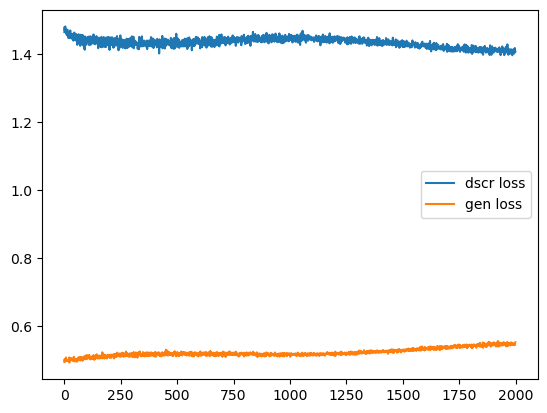

[ Info: Epoch 1: train step: 0, dscr loss: 1.4742366970136622, gen loss: 0.44602559708383965
[ Info: Epoch 21: train step: 200, dscr loss: 1.470117184347301, gen loss: 0.45120807937025
[ Info: Epoch 41: train step: 400, dscr loss: 1.446300988667108, gen loss: 0.469576815001748
[ Info: Epoch 61: train step: 600, dscr loss: 1.443321330501216, gen loss: 0.4763653661579123
[ Info: Epoch 81: train step: 800, dscr loss: 1.4436103895922945, gen loss: 0.4900566752669593
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4293050460018286, gen loss: 0.5040252125484166
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4150778226451242, gen loss: 0.5120743508995197
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4339872749807023, gen loss: 0.5227476370426719
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4197702264981997, gen loss: 0.5228801794224418
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4254917270556717, gen loss: 0.5346047518470951


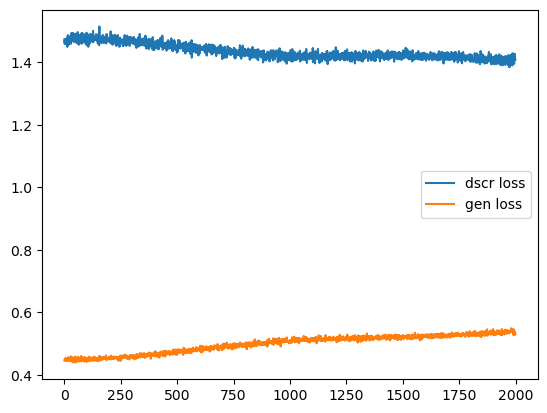

[ Info: Epoch 1: train step: 0, dscr loss: 1.3896622658367037, gen loss: 0.5182394537350227
[ Info: Epoch 21: train step: 200, dscr loss: 1.4255555859795208, gen loss: 0.521419279115188
[ Info: Epoch 41: train step: 400, dscr loss: 1.4142615285923577, gen loss: 0.5280645647583568
[ Info: Epoch 61: train step: 600, dscr loss: 1.4280213134099244, gen loss: 0.5400666008940548
[ Info: Epoch 81: train step: 800, dscr loss: 1.4175091323449407, gen loss: 0.5422647121027389
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4040835350947205, gen loss: 0.5375431486030924
[ Info: Epoch 121: train step: 1200, dscr loss: 1.415471694084729, gen loss: 0.5522305466902524
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4242082507950178, gen loss: 0.565532088736741
[ Info: Epoch 161: train step: 1600, dscr loss: 1.3989315280767738, gen loss: 0.5668109586039116
[ Info: Epoch 181: train step: 1800, dscr loss: 1.3924314798719484, gen loss: 0.5940482827249152


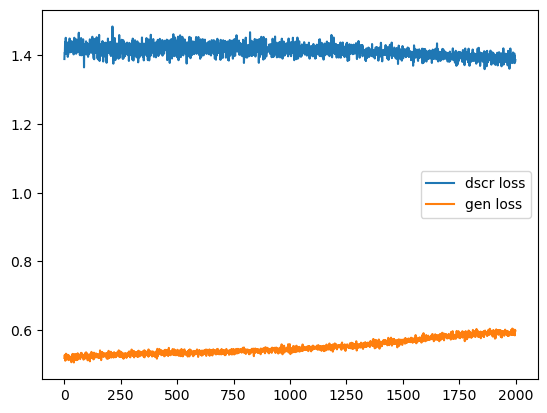

[ Info: Epoch 1: train step: 0, dscr loss: 1.4390204014325967, gen loss: 0.47324822418754214
[ Info: Epoch 21: train step: 200, dscr loss: 1.4535285221032865, gen loss: 0.47893466172489707
[ Info: Epoch 41: train step: 400, dscr loss: 1.4390675160408823, gen loss: 0.49382478368365057
[ Info: Epoch 61: train step: 600, dscr loss: 1.4339110436400604, gen loss: 0.5034509629518873
[ Info: Epoch 81: train step: 800, dscr loss: 1.4335682360311794, gen loss: 0.51070471398705
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4199765701390585, gen loss: 0.512253200837499
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4189052082932192, gen loss: 0.5303541628133982
[ Info: Epoch 141: train step: 1400, dscr loss: 1.410891351897301, gen loss: 0.5407014157057032
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4158369718976653, gen loss: 0.5520646307067946
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4173091542144518, gen loss: 0.5578194383990669


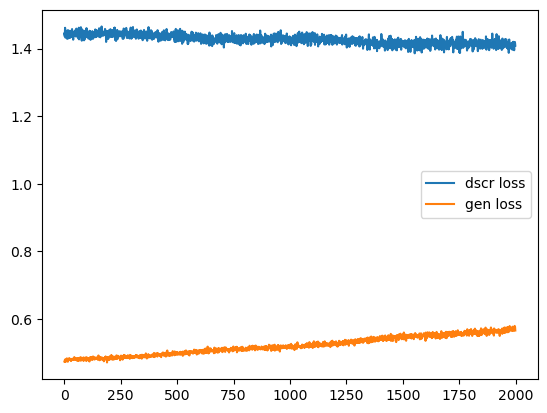

[ Info: Epoch 1: train step: 0, dscr loss: 1.46287901068746, gen loss: 0.4580742102474429
[ Info: Epoch 21: train step: 200, dscr loss: 1.4554468666684213, gen loss: 0.4664697294799275
[ Info: Epoch 41: train step: 400, dscr loss: 1.4440449360058105, gen loss: 0.4847951116244624
[ Info: Epoch 61: train step: 600, dscr loss: 1.424695647517176, gen loss: 0.4994946767445967
[ Info: Epoch 81: train step: 800, dscr loss: 1.4408865007810636, gen loss: 0.5150986910680713
[ Info: Epoch 101: train step: 1000, dscr loss: 1.420250008572168, gen loss: 0.5148635266409051
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4329302648401254, gen loss: 0.5214272842026015
[ Info: Epoch 141: train step: 1400, dscr loss: 1.442826734311876, gen loss: 0.5371761520490174
[ Info: Epoch 161: train step: 1600, dscr loss: 1.41589478375868, gen loss: 0.5460876622780433
[ Info: Epoch 181: train step: 1800, dscr loss: 1.3888870371682378, gen loss: 0.562642811712175


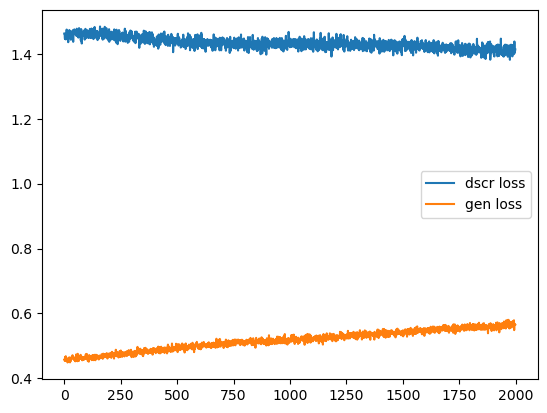

[ Info: Epoch 1: train step: 0, dscr loss: 1.4355514499916928, gen loss: 0.4769041543047454
[ Info: Epoch 21: train step: 200, dscr loss: 1.4420350610229864, gen loss: 0.4766992830490645
[ Info: Epoch 41: train step: 400, dscr loss: 1.451136327885793, gen loss: 0.48056282275724727
[ Info: Epoch 61: train step: 600, dscr loss: 1.4535704854491933, gen loss: 0.4936287752555005
[ Info: Epoch 81: train step: 800, dscr loss: 1.4414120436822582, gen loss: 0.5046542268063567
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4278789521242299, gen loss: 0.5159952501816124
[ Info: Epoch 121: train step: 1200, dscr loss: 1.418261150481549, gen loss: 0.516207269738908
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4196863306059653, gen loss: 0.5266086142383078
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4202833847653737, gen loss: 0.5377374070758444
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4117744504444425, gen loss: 0.5495236399143765


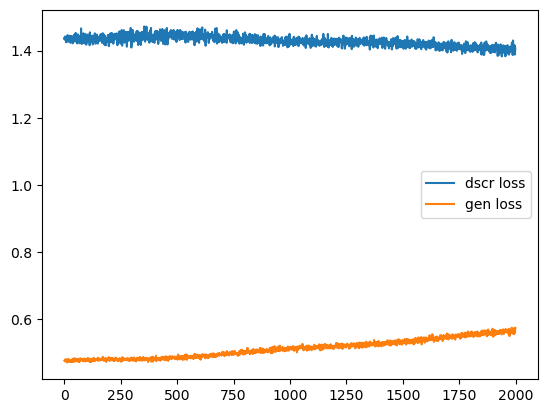

[ Info: Epoch 1: train step: 0, dscr loss: 1.4841844228649788, gen loss: 0.4411243672688212
[ Info: Epoch 21: train step: 200, dscr loss: 1.47222357051662, gen loss: 0.4536852441498502
[ Info: Epoch 41: train step: 400, dscr loss: 1.456882935810408, gen loss: 0.4697526417628468
[ Info: Epoch 61: train step: 600, dscr loss: 1.4453603913142554, gen loss: 0.46513249220190667
[ Info: Epoch 81: train step: 800, dscr loss: 1.4260278569694758, gen loss: 0.47493123520205716
[ Info: Epoch 101: train step: 1000, dscr loss: 1.44829210133456, gen loss: 0.4810048537087637
[ Info: Epoch 121: train step: 1200, dscr loss: 1.425888838602724, gen loss: 0.48321781131145713
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4151100322969163, gen loss: 0.490426079301799
[ Info: Epoch 161: train step: 1600, dscr loss: 1.3859399408214526, gen loss: 0.5058515176512158
[ Info: Epoch 181: train step: 1800, dscr loss: 1.3613310024361234, gen loss: 0.526414119242479


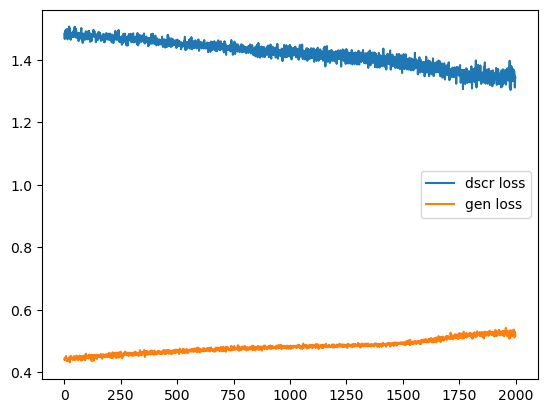

[ Info: Epoch 1: train step: 0, dscr loss: 1.4499539069412575, gen loss: 0.47922091237479253
[ Info: Epoch 21: train step: 200, dscr loss: 1.4367680784310206, gen loss: 0.48150250140185946
[ Info: Epoch 41: train step: 400, dscr loss: 1.440863365755957, gen loss: 0.4867181623245563
[ Info: Epoch 61: train step: 600, dscr loss: 1.4420396537328135, gen loss: 0.48815349445079365
[ Info: Epoch 81: train step: 800, dscr loss: 1.4229758890615782, gen loss: 0.49743339864189506
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4217462878618872, gen loss: 0.5067063150179196
[ Info: Epoch 121: train step: 1200, dscr loss: 1.407788846015507, gen loss: 0.5251014884470316
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4187939164350167, gen loss: 0.5335011388253997
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4138373466558032, gen loss: 0.5356622122395642
[ Info: Epoch 181: train step: 1800, dscr loss: 1.3977827501243643, gen loss: 0.5375381415490277


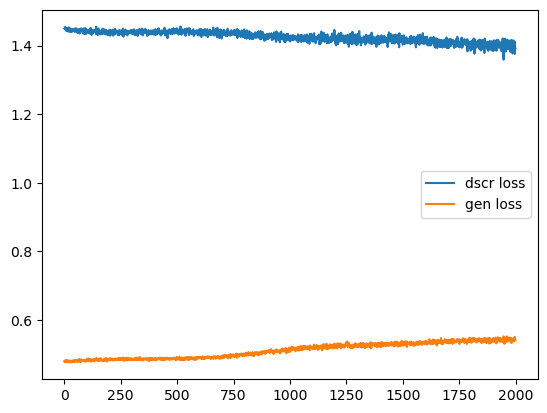

[ Info: Epoch 1: train step: 0, dscr loss: 1.4606240461091824, gen loss: 0.4881472785179234
[ Info: Epoch 21: train step: 200, dscr loss: 1.4368930752328815, gen loss: 0.5012716746325764
[ Info: Epoch 41: train step: 400, dscr loss: 1.4338756610030274, gen loss: 0.5143769565637462
[ Info: Epoch 61: train step: 600, dscr loss: 1.4280450110238854, gen loss: 0.510230334146002
[ Info: Epoch 81: train step: 800, dscr loss: 1.4365290119716674, gen loss: 0.5035361624272313
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4294867336259562, gen loss: 0.5128009138177
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4123320959173922, gen loss: 0.5216292396689158
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4026031399175054, gen loss: 0.5251448500090725
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4183672937538163, gen loss: 0.5285966527176569
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4061909003995012, gen loss: 0.5318851366198227


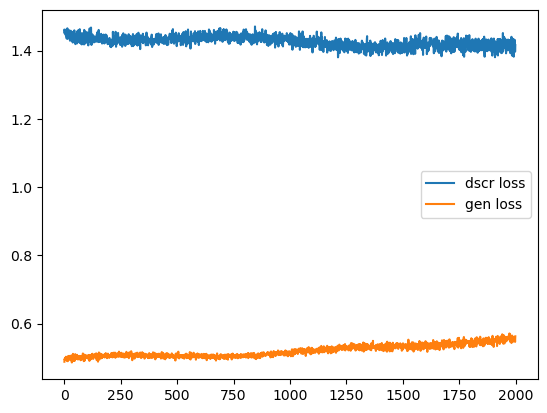

[ Info: Epoch 1: train step: 0, dscr loss: 1.4535290910056422, gen loss: 0.5081500562540021
[ Info: Epoch 21: train step: 200, dscr loss: 1.4458822672088023, gen loss: 0.5049507527000692
[ Info: Epoch 41: train step: 400, dscr loss: 1.4329939032744003, gen loss: 0.5103018115087566
[ Info: Epoch 61: train step: 600, dscr loss: 1.4491889359106922, gen loss: 0.51707449471972
[ Info: Epoch 81: train step: 800, dscr loss: 1.4322242967818681, gen loss: 0.5316816516644708
[ Info: Epoch 101: train step: 1000, dscr loss: 1.42967686807303, gen loss: 0.5367597425260113
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4198207516263281, gen loss: 0.5488333295288023
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4008721920372778, gen loss: 0.5607176603735939
[ Info: Epoch 161: train step: 1600, dscr loss: 1.3805596747715296, gen loss: 0.5631165375872285
[ Info: Epoch 181: train step: 1800, dscr loss: 1.3892979275288675, gen loss: 0.5777164091467951


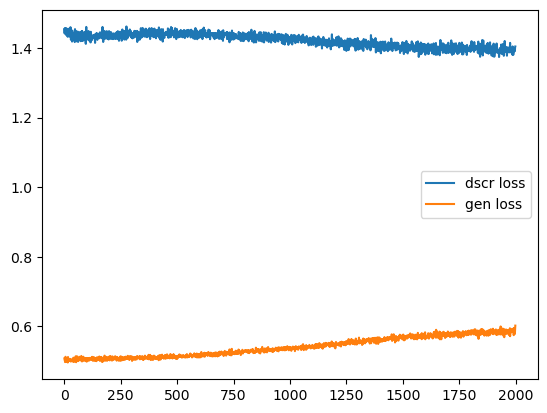

[ Info: Epoch 1: train step: 0, dscr loss: 1.4339603897249258, gen loss: 0.4823287027979687
[ Info: Epoch 21: train step: 200, dscr loss: 1.4270393583372596, gen loss: 0.49331949994542923
[ Info: Epoch 41: train step: 400, dscr loss: 1.4210014475567023, gen loss: 0.49305288450791696
[ Info: Epoch 61: train step: 600, dscr loss: 1.450342327652725, gen loss: 0.49279142741892173
[ Info: Epoch 81: train step: 800, dscr loss: 1.430996913811037, gen loss: 0.4957882558738846
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4321572830713052, gen loss: 0.5123018211881452
[ Info: Epoch 121: train step: 1200, dscr loss: 1.419518188200852, gen loss: 0.5314312095725117
[ Info: Epoch 141: train step: 1400, dscr loss: 1.413826640694051, gen loss: 0.563913376568664
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4131032709073583, gen loss: 0.5672209046872072
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4055247351808284, gen loss: 0.5739218351918184


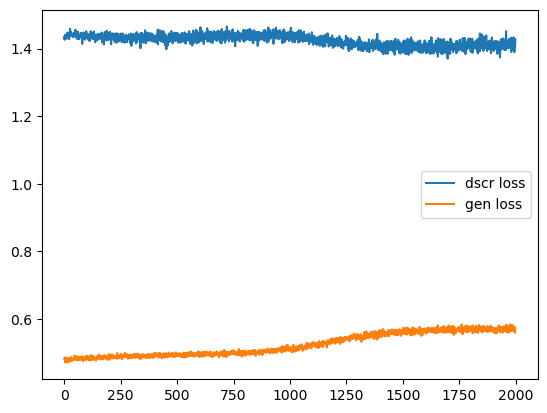

[ Info: Epoch 1: train step: 0, dscr loss: 1.468154706314909, gen loss: 0.4714756180414642
[ Info: Epoch 21: train step: 200, dscr loss: 1.4416712113225498, gen loss: 0.4930182076249468
[ Info: Epoch 41: train step: 400, dscr loss: 1.4184715553107523, gen loss: 0.5231021163479396
[ Info: Epoch 61: train step: 600, dscr loss: 1.403819024645284, gen loss: 0.5048820772795881
[ Info: Epoch 81: train step: 800, dscr loss: 1.4285392659198966, gen loss: 0.5274814684851223
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4400069957416664, gen loss: 0.5333320877782316
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4348700139023767, gen loss: 0.5215881067533342
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4497359569799775, gen loss: 0.5397781606007839
[ Info: Epoch 161: train step: 1600, dscr loss: 1.421969698170682, gen loss: 0.5438120232688679
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4167531391995092, gen loss: 0.5528940360979194


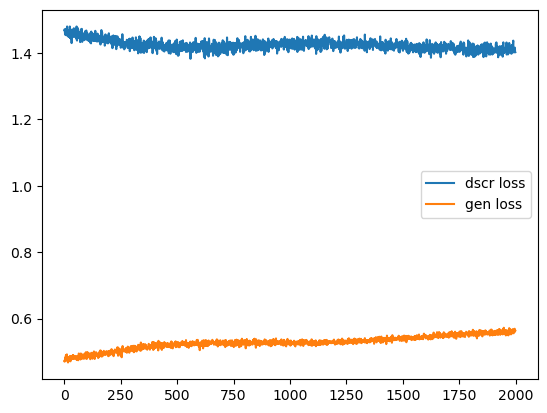

[ Info: Epoch 1: train step: 0, dscr loss: 1.5101036630777769, gen loss: 0.41763704532984763
[ Info: Epoch 21: train step: 200, dscr loss: 1.5436808526359647, gen loss: 0.42995700373372037
[ Info: Epoch 41: train step: 400, dscr loss: 1.525308077691411, gen loss: 0.42870402373927186
[ Info: Epoch 61: train step: 600, dscr loss: 1.4906799293840727, gen loss: 0.45619525298751057
[ Info: Epoch 81: train step: 800, dscr loss: 1.4604030407457544, gen loss: 0.4748191083824223
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4228131958070105, gen loss: 0.4980106995100841
[ Info: Epoch 121: train step: 1200, dscr loss: 1.39272646553223, gen loss: 0.5186932460061439
[ Info: Epoch 141: train step: 1400, dscr loss: 1.3975090299032664, gen loss: 0.5237766696726288
[ Info: Epoch 161: train step: 1600, dscr loss: 1.357112962687142, gen loss: 0.5412193494265959
[ Info: Epoch 181: train step: 1800, dscr loss: 1.3870355587959218, gen loss: 0.5310144976990595


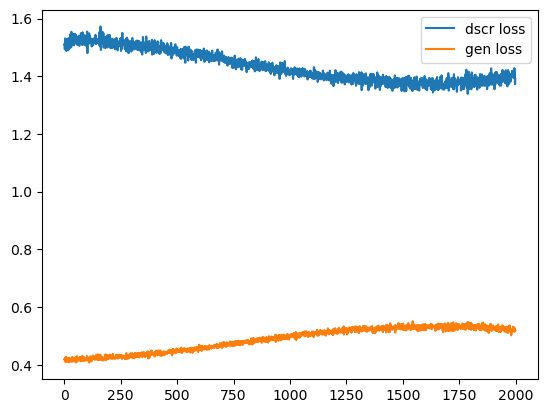

[ Info: Epoch 1: train step: 0, dscr loss: 1.3780303934593177, gen loss: 0.5155534029913761
[ Info: Epoch 21: train step: 200, dscr loss: 1.4242837755729547, gen loss: 0.5125651891641014
[ Info: Epoch 41: train step: 400, dscr loss: 1.4126473923860368, gen loss: 0.5043386390540775
[ Info: Epoch 61: train step: 600, dscr loss: 1.4353576289968106, gen loss: 0.5058897718656038
[ Info: Epoch 81: train step: 800, dscr loss: 1.437842193875243, gen loss: 0.5100629821410874
[ Info: Epoch 101: train step: 1000, dscr loss: 1.432094709619716, gen loss: 0.521957942224774
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4363439508059848, gen loss: 0.5296950117614561
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4201146253004806, gen loss: 0.5478800476264406
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4093647152507671, gen loss: 0.5800389345847605
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4142450658594914, gen loss: 0.5839917677040978


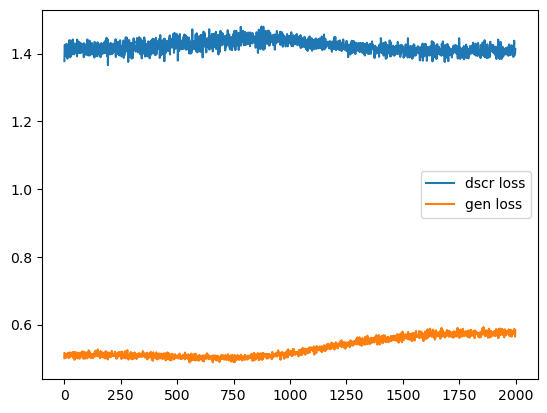

[ Info: Epoch 1: train step: 0, dscr loss: 1.4524768402599468, gen loss: 0.47892998117049496
[ Info: Epoch 21: train step: 200, dscr loss: 1.447368445198756, gen loss: 0.4833998272806841
[ Info: Epoch 41: train step: 400, dscr loss: 1.4378668143370097, gen loss: 0.4926385164229263
[ Info: Epoch 61: train step: 600, dscr loss: 1.4239495427277777, gen loss: 0.4915205474721821
[ Info: Epoch 81: train step: 800, dscr loss: 1.4472221334316484, gen loss: 0.5058065585388002
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4410636380028885, gen loss: 0.5144969223503107
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4319891104546436, gen loss: 0.5171875501804856
[ Info: Epoch 141: train step: 1400, dscr loss: 1.41347452771803, gen loss: 0.5384405163331554
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4146513826885792, gen loss: 0.5429375475770974
[ Info: Epoch 181: train step: 1800, dscr loss: 1.3979956658364432, gen loss: 0.56642626614638


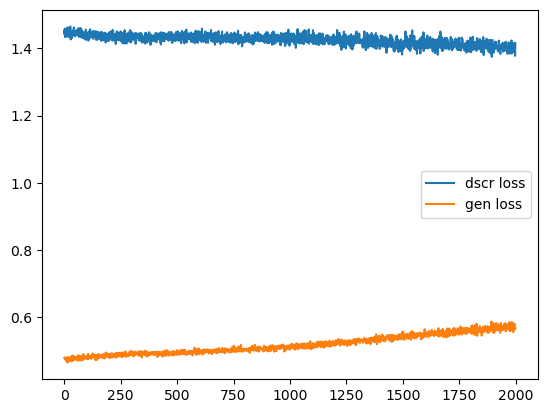

[ Info: Epoch 1: train step: 0, dscr loss: 1.4429258198693695, gen loss: 0.47807070577141375
[ Info: Epoch 21: train step: 200, dscr loss: 1.4320800309465844, gen loss: 0.4905348221024631
[ Info: Epoch 41: train step: 400, dscr loss: 1.4212538620380257, gen loss: 0.49970308810686737
[ Info: Epoch 61: train step: 600, dscr loss: 1.4393554735674372, gen loss: 0.49718216302879725
[ Info: Epoch 81: train step: 800, dscr loss: 1.4283434653372402, gen loss: 0.49514974905103015
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4392652841446467, gen loss: 0.504743613999825
[ Info: Epoch 121: train step: 1200, dscr loss: 1.451491789037743, gen loss: 0.5102113103347632
[ Info: Epoch 141: train step: 1400, dscr loss: 1.424663284653055, gen loss: 0.5390561611079856
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4108058241434764, gen loss: 0.5489825087884784
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4046590765709666, gen loss: 0.5662307047177433


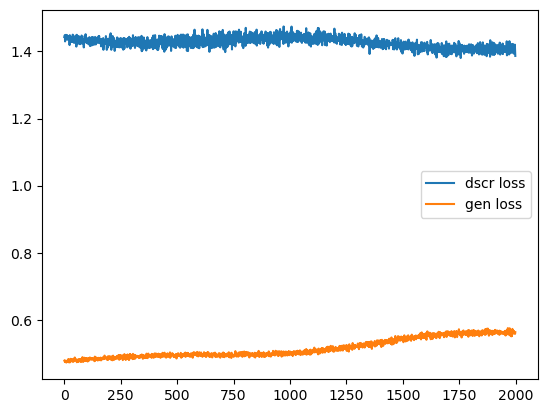

[ Info: Epoch 1: train step: 0, dscr loss: 1.4330576183430908, gen loss: 0.47451235823032667
[ Info: Epoch 21: train step: 200, dscr loss: 1.4237478803626273, gen loss: 0.4925093178000053
[ Info: Epoch 41: train step: 400, dscr loss: 1.4118550572595157, gen loss: 0.5033914828204927
[ Info: Epoch 61: train step: 600, dscr loss: 1.3846815688891518, gen loss: 0.49564336862986885
[ Info: Epoch 81: train step: 800, dscr loss: 1.409948019902588, gen loss: 0.5147487798592839
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4197394350332937, gen loss: 0.5104600616024872
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4250309799580734, gen loss: 0.5111761276766237
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4349473792952865, gen loss: 0.5086734125466008
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4277642467706524, gen loss: 0.5178430008695323
[ Info: Epoch 181: train step: 1800, dscr loss: 1.422247001161145, gen loss: 0.5187587985308507


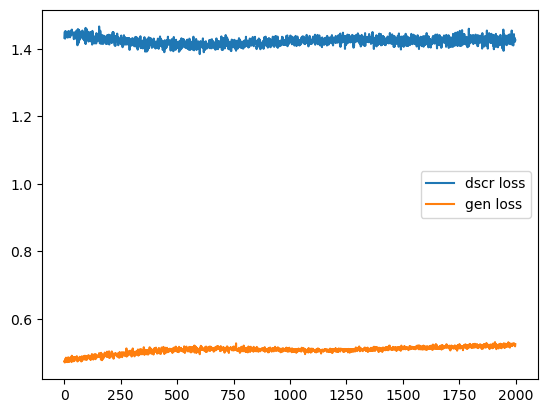

[ Info: Epoch 1: train step: 0, dscr loss: 1.420627135095046, gen loss: 0.512607104495557
[ Info: Epoch 21: train step: 200, dscr loss: 1.4127672460157297, gen loss: 0.5049785724411786
[ Info: Epoch 41: train step: 400, dscr loss: 1.4184781686206844, gen loss: 0.5155410122285816
[ Info: Epoch 61: train step: 600, dscr loss: 1.438276008158344, gen loss: 0.5164350392759353
[ Info: Epoch 81: train step: 800, dscr loss: 1.4124529980381642, gen loss: 0.5264274202559975
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4163743169097995, gen loss: 0.5428882078583862
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4345335606232732, gen loss: 0.5473744997478217
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4141890492729576, gen loss: 0.5535198772806897
[ Info: Epoch 161: train step: 1600, dscr loss: 1.398398277017515, gen loss: 0.578212515337745
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4005713366722146, gen loss: 0.5852633516990207


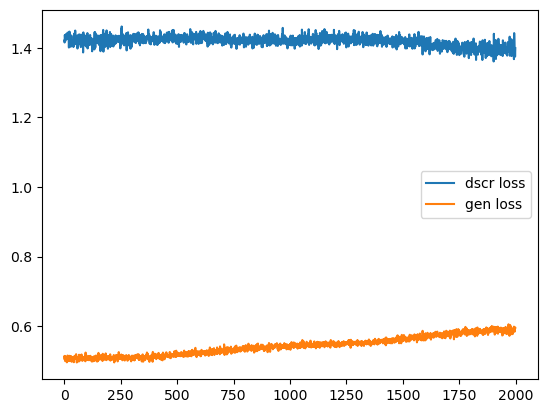

[ Info: Epoch 1: train step: 0, dscr loss: 1.4550661323617118, gen loss: 0.49163158434178156
[ Info: Epoch 21: train step: 200, dscr loss: 1.424334070877388, gen loss: 0.48936176587938895
[ Info: Epoch 41: train step: 400, dscr loss: 1.4414109168605143, gen loss: 0.48311416809292745
[ Info: Epoch 61: train step: 600, dscr loss: 1.4308119238893606, gen loss: 0.486048943364502
[ Info: Epoch 81: train step: 800, dscr loss: 1.420817642386714, gen loss: 0.4963323621699927
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4268829944248087, gen loss: 0.5162419082811897
[ Info: Epoch 121: train step: 1200, dscr loss: 1.44368238949493, gen loss: 0.5237310978516073
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4305475447453628, gen loss: 0.5290949044813787
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4201461560301119, gen loss: 0.5450042647645426
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4141526502728943, gen loss: 0.560550827231494


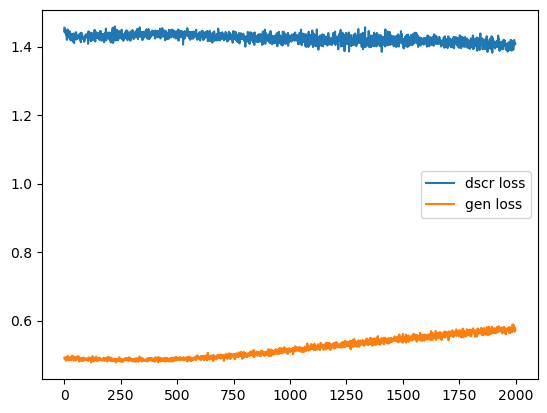

[ Info: Epoch 1: train step: 0, dscr loss: 1.459510491494246, gen loss: 0.4692245700426081
[ Info: Epoch 21: train step: 200, dscr loss: 1.4473689506983092, gen loss: 0.4831887887480051
[ Info: Epoch 41: train step: 400, dscr loss: 1.4388221419207203, gen loss: 0.49372269506301625
[ Info: Epoch 61: train step: 600, dscr loss: 1.4272983326156712, gen loss: 0.4977428016345119
[ Info: Epoch 81: train step: 800, dscr loss: 1.4343048404336938, gen loss: 0.49631286122484825
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4366729810077485, gen loss: 0.5055836329780986
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4248656998170677, gen loss: 0.5108545061043696
[ Info: Epoch 141: train step: 1400, dscr loss: 1.434775862918409, gen loss: 0.5177772912827798
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4248042742774665, gen loss: 0.5253877828948802
[ Info: Epoch 181: train step: 1800, dscr loss: 1.410767553699749, gen loss: 0.535971143356286


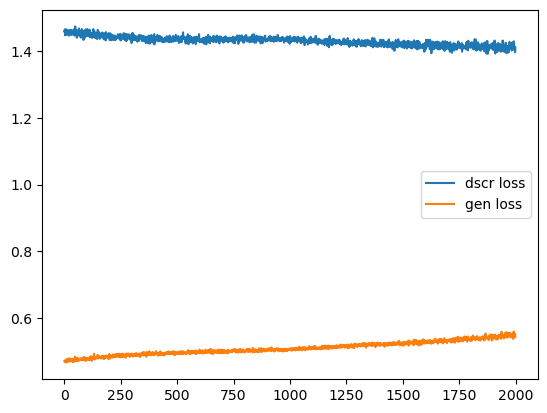

[ Info: Epoch 1: train step: 0, dscr loss: 1.4416724582736216, gen loss: 0.47168618535348655
[ Info: Epoch 21: train step: 200, dscr loss: 1.4549517970034724, gen loss: 0.4702068740311484
[ Info: Epoch 41: train step: 400, dscr loss: 1.4485537636877175, gen loss: 0.4768534639132136
[ Info: Epoch 61: train step: 600, dscr loss: 1.4417584213532857, gen loss: 0.4826599590306062
[ Info: Epoch 81: train step: 800, dscr loss: 1.4396676507982757, gen loss: 0.4906885010876937
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4298412470075181, gen loss: 0.49456354422056864
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4267454423635137, gen loss: 0.505227866119885
[ Info: Epoch 141: train step: 1400, dscr loss: 1.431643411191625, gen loss: 0.5121988633981553
[ Info: Epoch 161: train step: 1600, dscr loss: 1.422158030524812, gen loss: 0.5159008917717034
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4144695481763288, gen loss: 0.5319467293121855


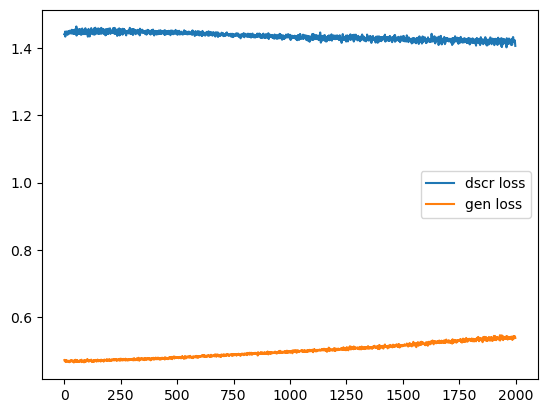

[ Info: Epoch 1: train step: 0, dscr loss: 1.4368428398809798, gen loss: 0.4665604291799403
[ Info: Epoch 21: train step: 200, dscr loss: 1.4484384279912061, gen loss: 0.47020344926209856
[ Info: Epoch 41: train step: 400, dscr loss: 1.4717492586352439, gen loss: 0.4711933136984494
[ Info: Epoch 61: train step: 600, dscr loss: 1.4626044910968838, gen loss: 0.4707076026394935
[ Info: Epoch 81: train step: 800, dscr loss: 1.4601282792641785, gen loss: 0.47908285454747057
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4483466148146502, gen loss: 0.4981830178976933
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4317244488373984, gen loss: 0.5127388515655106
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4043756893893493, gen loss: 0.524279848334695
[ Info: Epoch 161: train step: 1600, dscr loss: 1.3926117207860007, gen loss: 0.5568299619516792
[ Info: Epoch 181: train step: 1800, dscr loss: 1.3810379923009304, gen loss: 0.5516148705239983


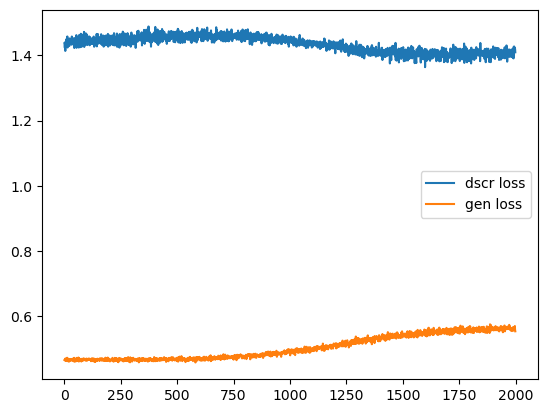

[ Info: Epoch 1: train step: 0, dscr loss: 1.442222351136469, gen loss: 0.49887767651644066
[ Info: Epoch 21: train step: 200, dscr loss: 1.4367311987535885, gen loss: 0.4994328737071237
[ Info: Epoch 41: train step: 400, dscr loss: 1.4381430988224562, gen loss: 0.49433277779620516
[ Info: Epoch 61: train step: 600, dscr loss: 1.433485019930243, gen loss: 0.5001907282591828
[ Info: Epoch 81: train step: 800, dscr loss: 1.4312357186027675, gen loss: 0.5055194199541664
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4185198663620322, gen loss: 0.5081216909851705
[ Info: Epoch 121: train step: 1200, dscr loss: 1.415385893087349, gen loss: 0.521279352287769
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4156457871073782, gen loss: 0.5351477176737233
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4115181605119695, gen loss: 0.5278606464492437
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4331658907660285, gen loss: 0.5516646006329273


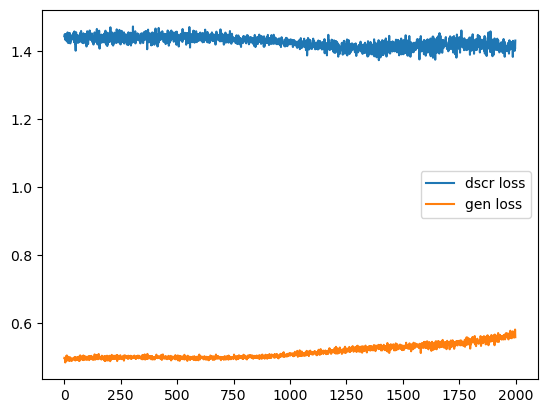

[ Info: Epoch 1: train step: 0, dscr loss: 1.4572822464466137, gen loss: 0.47368464604824595
[ Info: Epoch 21: train step: 200, dscr loss: 1.4297628968603782, gen loss: 0.4888621738205655
[ Info: Epoch 41: train step: 400, dscr loss: 1.4373223032714515, gen loss: 0.4932542546337697
[ Info: Epoch 61: train step: 600, dscr loss: 1.4407403410565718, gen loss: 0.48500619446797083
[ Info: Epoch 81: train step: 800, dscr loss: 1.436436525567282, gen loss: 0.49455841035117054
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4419649805110621, gen loss: 0.496033429747945
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4418132191310853, gen loss: 0.49738083943176575
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4393244699158143, gen loss: 0.5054923518573906
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4262565323383898, gen loss: 0.5069823316523424
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4290134906850525, gen loss: 0.5250688489120595


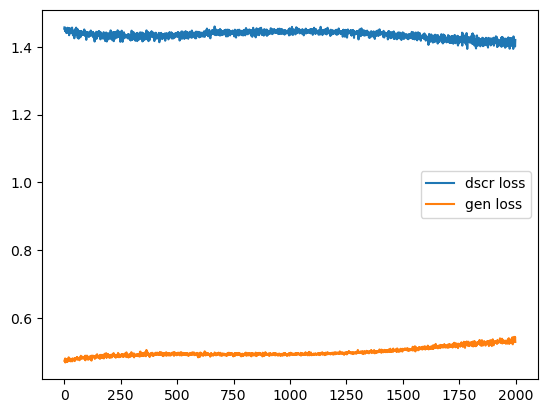

[ Info: Epoch 1: train step: 0, dscr loss: 1.4376133592895417, gen loss: 0.4749989337119934
[ Info: Epoch 21: train step: 200, dscr loss: 1.4479854032017083, gen loss: 0.4746423570378506
[ Info: Epoch 41: train step: 400, dscr loss: 1.461893243553099, gen loss: 0.47460644052434164
[ Info: Epoch 61: train step: 600, dscr loss: 1.4444162348912495, gen loss: 0.4817487191196379
[ Info: Epoch 81: train step: 800, dscr loss: 1.4418939800758943, gen loss: 0.49071633103538737
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4241296956041407, gen loss: 0.4976147502535081
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4115167158242712, gen loss: 0.5163126685476331
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4157532636116679, gen loss: 0.5234143722988697
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4196703806237545, gen loss: 0.5245620009792166
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4085521574679483, gen loss: 0.5246455853079723


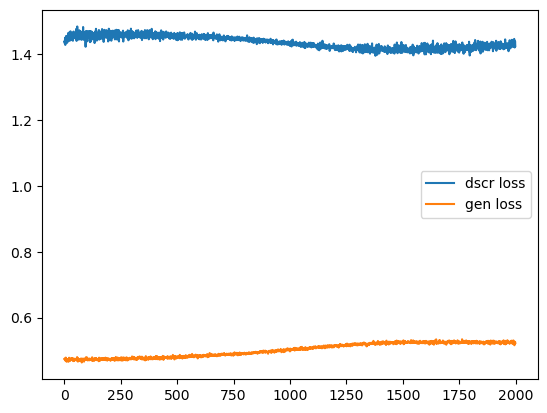

[ Info: Epoch 1: train step: 0, dscr loss: 1.4399594323580027, gen loss: 0.4692958285049633
[ Info: Epoch 21: train step: 200, dscr loss: 1.4210613702369954, gen loss: 0.4867728126449984
[ Info: Epoch 41: train step: 400, dscr loss: 1.427512896074437, gen loss: 0.4885993477118306
[ Info: Epoch 61: train step: 600, dscr loss: 1.4363649096370161, gen loss: 0.4930600081559479
[ Info: Epoch 81: train step: 800, dscr loss: 1.437401060163649, gen loss: 0.49377995134787495
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4417171721967978, gen loss: 0.49283276699993267
[ Info: Epoch 121: train step: 1200, dscr loss: 1.421008363964245, gen loss: 0.5025979579210506
[ Info: Epoch 141: train step: 1400, dscr loss: 1.426126476241821, gen loss: 0.5174691944214969
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4090879779217276, gen loss: 0.5312101001688315
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4302671644145133, gen loss: 0.523716936619267


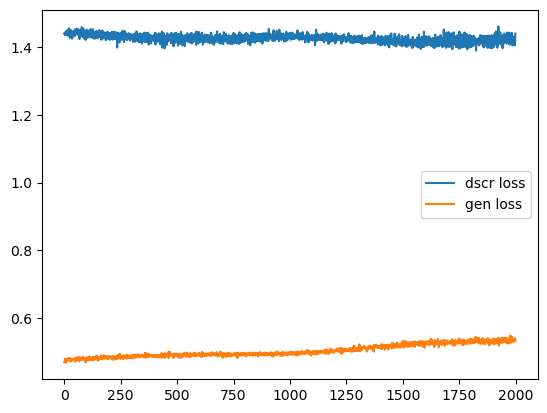

[ Info: Epoch 1: train step: 0, dscr loss: 1.4499787018447234, gen loss: 0.4570412718149284
[ Info: Epoch 21: train step: 200, dscr loss: 1.4412739633973333, gen loss: 0.46745778530992527
[ Info: Epoch 41: train step: 400, dscr loss: 1.4766462338616009, gen loss: 0.4784919649592237
[ Info: Epoch 61: train step: 600, dscr loss: 1.4632644405184305, gen loss: 0.47861334317682613
[ Info: Epoch 81: train step: 800, dscr loss: 1.4513432777338704, gen loss: 0.4838413038043592
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4392059818789926, gen loss: 0.49498292036510066
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4266592597730476, gen loss: 0.5258090361894985
[ Info: Epoch 141: train step: 1400, dscr loss: 1.3909847227029237, gen loss: 0.5395921820349671
[ Info: Epoch 161: train step: 1600, dscr loss: 1.399324342570837, gen loss: 0.5430714352029257
[ Info: Epoch 181: train step: 1800, dscr loss: 1.412262567010575, gen loss: 0.551817374188834


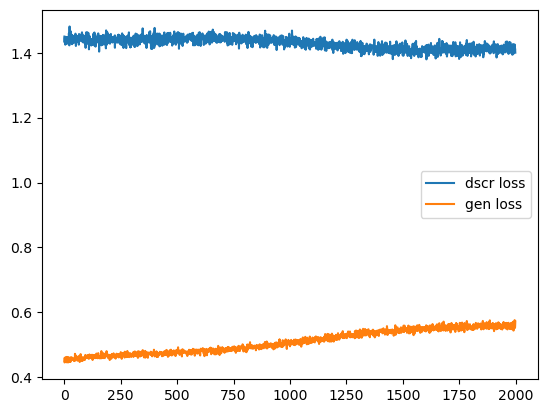

[ Info: Epoch 1: train step: 0, dscr loss: 1.448030397765081, gen loss: 0.47396156725958094
[ Info: Epoch 21: train step: 200, dscr loss: 1.44093612197745, gen loss: 0.4783414147885092
[ Info: Epoch 41: train step: 400, dscr loss: 1.4351706765498224, gen loss: 0.4857344689065268
[ Info: Epoch 61: train step: 600, dscr loss: 1.443155297713799, gen loss: 0.49386958889840815
[ Info: Epoch 81: train step: 800, dscr loss: 1.4472608752652398, gen loss: 0.4949780961593404
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4246391116595998, gen loss: 0.5137959806699164
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4113208701898214, gen loss: 0.5317168264368638
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4217904723444983, gen loss: 0.5444119116280534
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4326775715528342, gen loss: 0.5556652465547074
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4066825882419864, gen loss: 0.5635330404982981


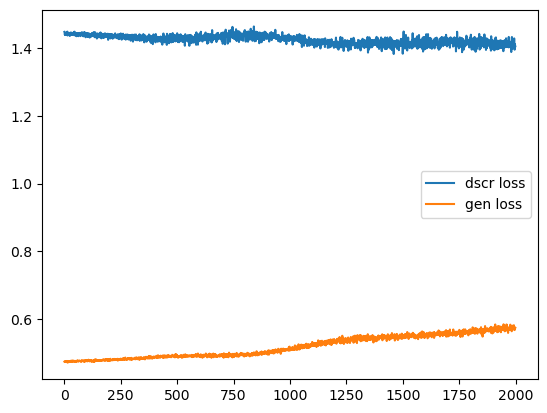

[ Info: Epoch 1: train step: 0, dscr loss: 1.4663211151666111, gen loss: 0.4950734509625764
[ Info: Epoch 21: train step: 200, dscr loss: 1.475090232383224, gen loss: 0.5026584429882195
[ Info: Epoch 41: train step: 400, dscr loss: 1.4470047440798226, gen loss: 0.5163868751461365
[ Info: Epoch 61: train step: 600, dscr loss: 1.4334698673741642, gen loss: 0.5137543331157423
[ Info: Epoch 81: train step: 800, dscr loss: 1.4396817598901692, gen loss: 0.5157921841372569
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4441313665727762, gen loss: 0.5252543554061352
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4333928189911727, gen loss: 0.5299516470724146
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4182786836295551, gen loss: 0.5313271119935841
[ Info: Epoch 161: train step: 1600, dscr loss: 1.3973858087520998, gen loss: 0.537992942956687
[ Info: Epoch 181: train step: 1800, dscr loss: 1.403242760993591, gen loss: 0.5469003734310607


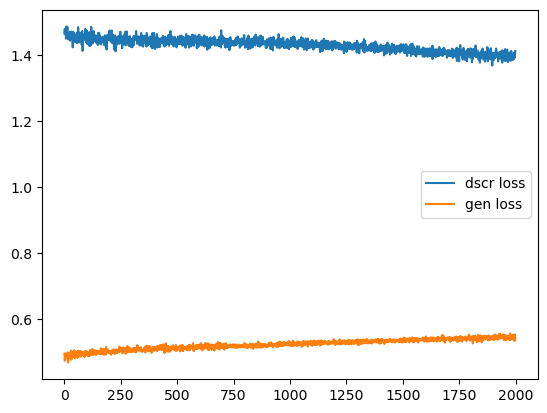

[ Info: Epoch 1: train step: 0, dscr loss: 1.4664935657114109, gen loss: 0.4923771438513118
[ Info: Epoch 21: train step: 200, dscr loss: 1.4531720976155638, gen loss: 0.5030498122681434
[ Info: Epoch 41: train step: 400, dscr loss: 1.4612372197743027, gen loss: 0.5022484029716616
[ Info: Epoch 61: train step: 600, dscr loss: 1.4372525141233798, gen loss: 0.5057501935529074
[ Info: Epoch 81: train step: 800, dscr loss: 1.458504930981912, gen loss: 0.5077073862651059
[ Info: Epoch 101: train step: 1000, dscr loss: 1.430506077805238, gen loss: 0.5150130044053577
[ Info: Epoch 121: train step: 1200, dscr loss: 1.407929978997859, gen loss: 0.5264512343607924
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4114084559401248, gen loss: 0.5289268932233877
[ Info: Epoch 161: train step: 1600, dscr loss: 1.3853109816153575, gen loss: 0.5356288286237416
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4052099873524546, gen loss: 0.5341939981561193


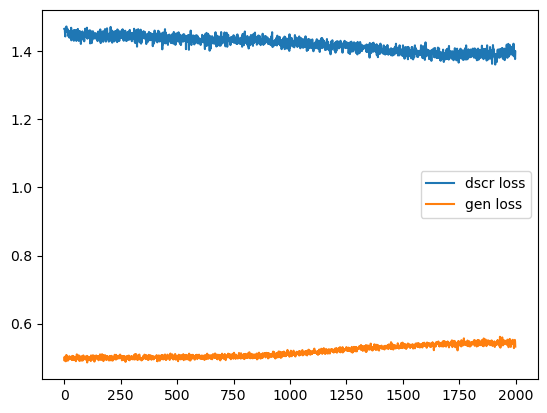

[ Info: Epoch 1: train step: 0, dscr loss: 1.4875559446888933, gen loss: 0.44068897494103004
[ Info: Epoch 21: train step: 200, dscr loss: 1.44357232657707, gen loss: 0.4731043381977931
[ Info: Epoch 41: train step: 400, dscr loss: 1.4248837072614495, gen loss: 0.4894381624560246
[ Info: Epoch 61: train step: 600, dscr loss: 1.4041661007728776, gen loss: 0.5093109567381814
[ Info: Epoch 81: train step: 800, dscr loss: 1.3671673824030504, gen loss: 0.5140327208746023
[ Info: Epoch 101: train step: 1000, dscr loss: 1.3937609814700151, gen loss: 0.5109673466153296
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4189032189190895, gen loss: 0.5007586256747208
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4174215215231778, gen loss: 0.49419744493186174
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4306066279856384, gen loss: 0.5014844636056769
[ Info: Epoch 181: train step: 1800, dscr loss: 1.453543049178813, gen loss: 0.5017624378341853


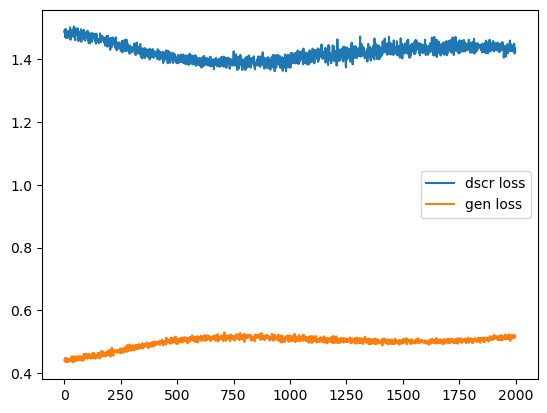

[ Info: Epoch 1: train step: 0, dscr loss: 1.4598467702110207, gen loss: 0.48869859616196737
[ Info: Epoch 21: train step: 200, dscr loss: 1.4439451820289173, gen loss: 0.5089830554120569
[ Info: Epoch 41: train step: 400, dscr loss: 1.4322119064433751, gen loss: 0.4997050326970152
[ Info: Epoch 61: train step: 600, dscr loss: 1.4446352714844046, gen loss: 0.5036669144788841
[ Info: Epoch 81: train step: 800, dscr loss: 1.4247872985186794, gen loss: 0.506734462002171
[ Info: Epoch 101: train step: 1000, dscr loss: 1.3968386658047303, gen loss: 0.510850626170577
[ Info: Epoch 121: train step: 1200, dscr loss: 1.3827055292099497, gen loss: 0.5231509006121662
[ Info: Epoch 141: train step: 1400, dscr loss: 1.3998176155107855, gen loss: 0.5342657718232634
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4141851167283994, gen loss: 0.5356632124798959
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4012050160266407, gen loss: 0.5530876312340701


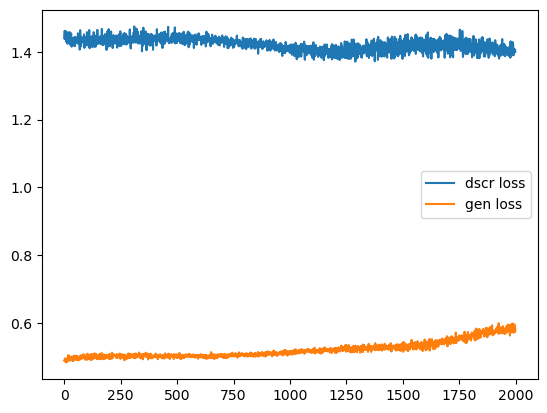

[ Info: Epoch 1: train step: 0, dscr loss: 1.4516587010765816, gen loss: 0.48719036750534295
[ Info: Epoch 21: train step: 200, dscr loss: 1.4263285071063345, gen loss: 0.5076493801692421
[ Info: Epoch 41: train step: 400, dscr loss: 1.4233102164372196, gen loss: 0.5080277777185856
[ Info: Epoch 61: train step: 600, dscr loss: 1.4256630180260823, gen loss: 0.5107351237216785
[ Info: Epoch 81: train step: 800, dscr loss: 1.436921266160523, gen loss: 0.5095371424988402
[ Info: Epoch 101: train step: 1000, dscr loss: 1.430013207740858, gen loss: 0.5086133916075086
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4186258520963297, gen loss: 0.5140676830299443
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4086470541771956, gen loss: 0.52761168056166
[ Info: Epoch 161: train step: 1600, dscr loss: 1.3815793975115223, gen loss: 0.533302725988543
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4423716992793603, gen loss: 0.5398847209859403


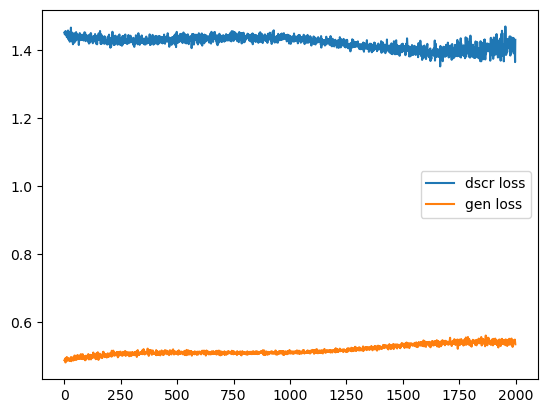

[ Info: Epoch 1: train step: 0, dscr loss: 1.445706729443562, gen loss: 0.49674113295314615
[ Info: Epoch 21: train step: 200, dscr loss: 1.440071623670234, gen loss: 0.5067083633040734
[ Info: Epoch 41: train step: 400, dscr loss: 1.422903868446623, gen loss: 0.5139248587994832
[ Info: Epoch 61: train step: 600, dscr loss: 1.442345557141362, gen loss: 0.5067620681174729
[ Info: Epoch 81: train step: 800, dscr loss: 1.4469484549603442, gen loss: 0.5022058384547395
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4361572775076688, gen loss: 0.5084488343900102
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4400783114249522, gen loss: 0.5108860439112384
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4321690070273854, gen loss: 0.5293441165114222
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4078049132018167, gen loss: 0.5439503630339524
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4061585419887126, gen loss: 0.545160297591024


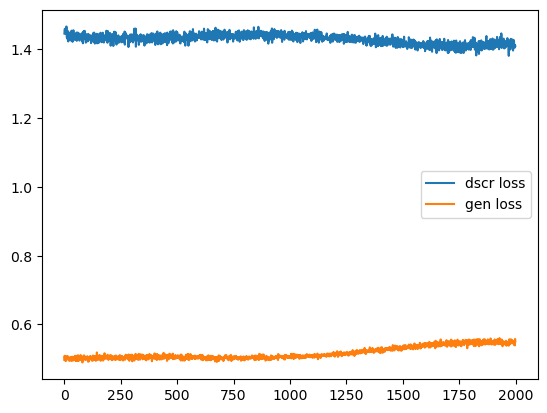

[ Info: Epoch 1: train step: 0, dscr loss: 1.440285912613168, gen loss: 0.47268981987852515
[ Info: Epoch 21: train step: 200, dscr loss: 1.438075481865905, gen loss: 0.47890572995311415
[ Info: Epoch 41: train step: 400, dscr loss: 1.4310286194516395, gen loss: 0.4895357973105324
[ Info: Epoch 61: train step: 600, dscr loss: 1.434209281039101, gen loss: 0.4892397592741022
[ Info: Epoch 81: train step: 800, dscr loss: 1.4342960929089386, gen loss: 0.4940609924395477
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4363245445276451, gen loss: 0.49575110301923286
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4376438457891711, gen loss: 0.5065035334652944
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4216771807214763, gen loss: 0.5118693315988185
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4174494135655777, gen loss: 0.5125210607923895
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4282456884969632, gen loss: 0.5291718223661658


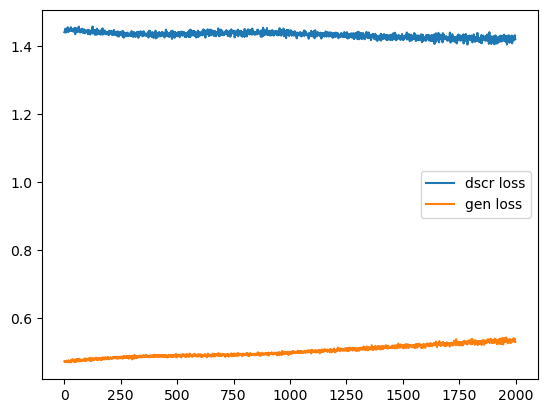

[ Info: Epoch 1: train step: 0, dscr loss: 1.4439550365051836, gen loss: 0.46799252025340116
[ Info: Epoch 21: train step: 200, dscr loss: 1.423127194247815, gen loss: 0.49140926759677006
[ Info: Epoch 41: train step: 400, dscr loss: 1.4256191223985941, gen loss: 0.4985034305597508
[ Info: Epoch 61: train step: 600, dscr loss: 1.4250991845411307, gen loss: 0.5097651196440739
[ Info: Epoch 81: train step: 800, dscr loss: 1.4247408347426758, gen loss: 0.510760555358986
[ Info: Epoch 101: train step: 1000, dscr loss: 1.42353503704871, gen loss: 0.5107754088125747
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4273199001260273, gen loss: 0.5076805181391694
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4227605214391403, gen loss: 0.5160905854423642
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4232495940107621, gen loss: 0.5214501473732979
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4037317235231264, gen loss: 0.5354326814524386


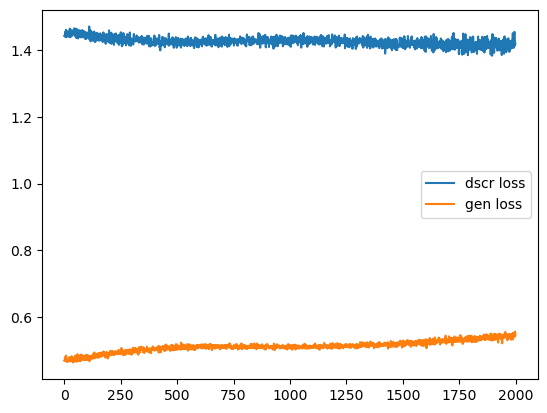

[ Info: Epoch 1: train step: 0, dscr loss: 1.4330020401897912, gen loss: 0.4639533292749885
[ Info: Epoch 21: train step: 200, dscr loss: 1.430840595102801, gen loss: 0.479953548421139
[ Info: Epoch 41: train step: 400, dscr loss: 1.410125423301363, gen loss: 0.49859235610000546
[ Info: Epoch 61: train step: 600, dscr loss: 1.4008217692449616, gen loss: 0.49920935821549484
[ Info: Epoch 81: train step: 800, dscr loss: 1.400330919093227, gen loss: 0.49150598680414587
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4637705009719912, gen loss: 0.49292226957352464
[ Info: Epoch 121: train step: 1200, dscr loss: 1.457316467173586, gen loss: 0.4982811531443842
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4554989421641986, gen loss: 0.5048731890699678
[ Info: Epoch 161: train step: 1600, dscr loss: 1.425729633255645, gen loss: 0.5260526605013031
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4186656199833731, gen loss: 0.55191014894735


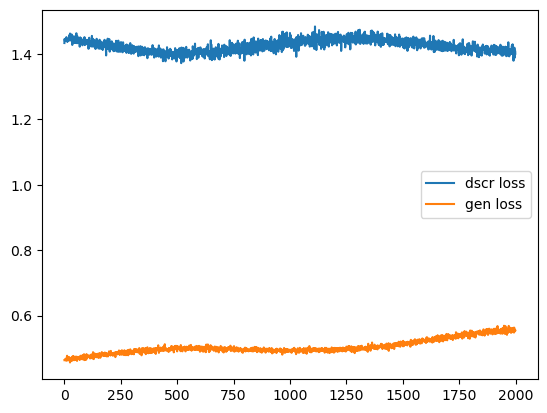

[ Info: Epoch 1: train step: 0, dscr loss: 1.4591542064984053, gen loss: 0.4617742951088276
[ Info: Epoch 21: train step: 200, dscr loss: 1.4334889492677052, gen loss: 0.4814062848507375
[ Info: Epoch 41: train step: 400, dscr loss: 1.4191427580404867, gen loss: 0.4884953478385604
[ Info: Epoch 61: train step: 600, dscr loss: 1.4268098586904472, gen loss: 0.48402367425990733
[ Info: Epoch 81: train step: 800, dscr loss: 1.4543960213750478, gen loss: 0.4735828880969601
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4425636094519843, gen loss: 0.49234019013333785
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4620223681443174, gen loss: 0.4930474300944994
[ Info: Epoch 141: train step: 1400, dscr loss: 1.441913514871322, gen loss: 0.4993735230965215
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4312181908527775, gen loss: 0.5219759537099175
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4168366118775226, gen loss: 0.5285227972962591


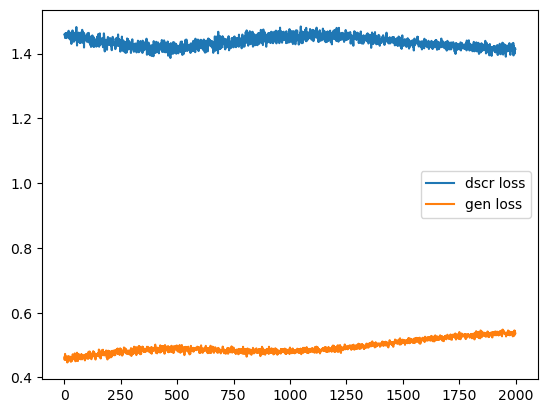

[ Info: Epoch 1: train step: 0, dscr loss: 1.461299309259949, gen loss: 0.449570100905439
[ Info: Epoch 21: train step: 200, dscr loss: 1.4588364241007266, gen loss: 0.46142430711302856
[ Info: Epoch 41: train step: 400, dscr loss: 1.451371101168835, gen loss: 0.47123863697075075
[ Info: Epoch 61: train step: 600, dscr loss: 1.440064088833035, gen loss: 0.47678791810243454
[ Info: Epoch 81: train step: 800, dscr loss: 1.4386396456095878, gen loss: 0.48728032862159165
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4245628552016598, gen loss: 0.4944674000351922
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4278963178746655, gen loss: 0.49820384062313394
[ Info: Epoch 141: train step: 1400, dscr loss: 1.434381140694796, gen loss: 0.5155163037175315
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4126523010267027, gen loss: 0.5232467388376102
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4105849284977114, gen loss: 0.5251574954170501


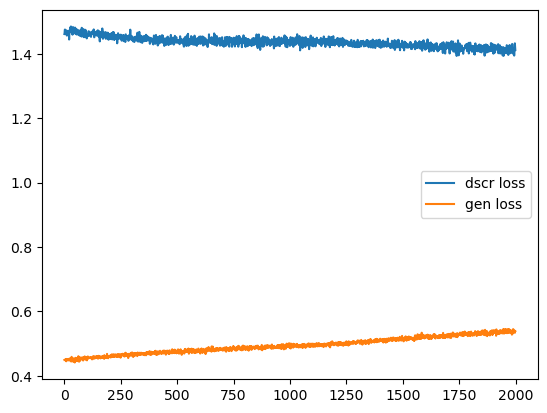

[ Info: Epoch 1: train step: 0, dscr loss: 1.4481202972483485, gen loss: 0.4504749897986038
[ Info: Epoch 21: train step: 200, dscr loss: 1.4602932648142122, gen loss: 0.45163347582007485
[ Info: Epoch 41: train step: 400, dscr loss: 1.436594621086124, gen loss: 0.46033147233004046
[ Info: Epoch 61: train step: 600, dscr loss: 1.411212706931794, gen loss: 0.4896658402658358
[ Info: Epoch 81: train step: 800, dscr loss: 1.4058160596934186, gen loss: 0.48912893246439565
[ Info: Epoch 101: train step: 1000, dscr loss: 1.418388744124398, gen loss: 0.49942643499772515
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4403934087551136, gen loss: 0.5015962124570552
[ Info: Epoch 141: train step: 1400, dscr loss: 1.474863573156088, gen loss: 0.5058236932865043
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4441070006746881, gen loss: 0.5360797036184615
[ Info: Epoch 181: train step: 1800, dscr loss: 1.409211367737346, gen loss: 0.5727068193918394


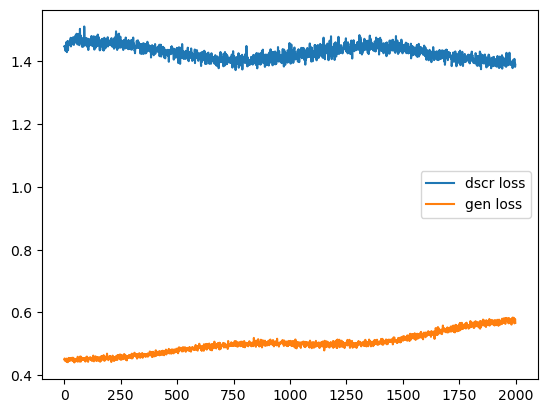

[ Info: Epoch 1: train step: 0, dscr loss: 1.4445091615990486, gen loss: 0.4404214884359147
[ Info: Epoch 21: train step: 200, dscr loss: 1.494897988980902, gen loss: 0.44677098152004335
[ Info: Epoch 41: train step: 400, dscr loss: 1.4685635620852968, gen loss: 0.4522529451570824
[ Info: Epoch 61: train step: 600, dscr loss: 1.452518335831563, gen loss: 0.46000459529569154
[ Info: Epoch 81: train step: 800, dscr loss: 1.4599243387817198, gen loss: 0.4609966301906081
[ Info: Epoch 101: train step: 1000, dscr loss: 1.446391371911263, gen loss: 0.4745265545997063
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4430923119293806, gen loss: 0.4843399598807177
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4228968809089841, gen loss: 0.49980401257738377
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4171023185779215, gen loss: 0.49583984311451035
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4150544104449778, gen loss: 0.5044252247180067


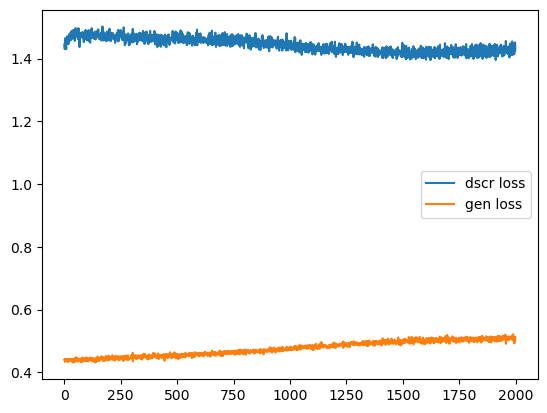

[ Info: Epoch 1: train step: 0, dscr loss: 1.4425825179903675, gen loss: 0.45381906600223415
[ Info: Epoch 21: train step: 200, dscr loss: 1.4612488304205706, gen loss: 0.464889545785634
[ Info: Epoch 41: train step: 400, dscr loss: 1.4402316351899964, gen loss: 0.4713655879265141
[ Info: Epoch 61: train step: 600, dscr loss: 1.430066380583789, gen loss: 0.49001805978990576
[ Info: Epoch 81: train step: 800, dscr loss: 1.4309702014648225, gen loss: 0.4848642504843953
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4415608611252413, gen loss: 0.4968050571381298
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4447037801262597, gen loss: 0.5050243033878337
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4307698239624145, gen loss: 0.5148418507538907
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4294355258299176, gen loss: 0.5320016872817429
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4177167518163165, gen loss: 0.5408063265289832


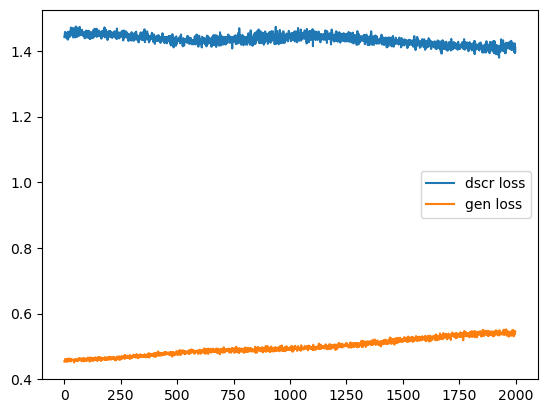

[ Info: Epoch 1: train step: 0, dscr loss: 1.451480869052733, gen loss: 0.5056246145982444
[ Info: Epoch 21: train step: 200, dscr loss: 1.4434675888583304, gen loss: 0.5086064311937083
[ Info: Epoch 41: train step: 400, dscr loss: 1.4255382317912573, gen loss: 0.5148647036078783
[ Info: Epoch 61: train step: 600, dscr loss: 1.4284878866856308, gen loss: 0.5164150489925872
[ Info: Epoch 81: train step: 800, dscr loss: 1.4276132019485066, gen loss: 0.5239860779708669
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4258843398723042, gen loss: 0.5381133835452843
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4253542130296624, gen loss: 0.5486349662353835
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4101487722395856, gen loss: 0.5597840972065317
[ Info: Epoch 161: train step: 1600, dscr loss: 1.416568611207691, gen loss: 0.5590694501861806
[ Info: Epoch 181: train step: 1800, dscr loss: 1.3975205001637367, gen loss: 0.5822814250196171


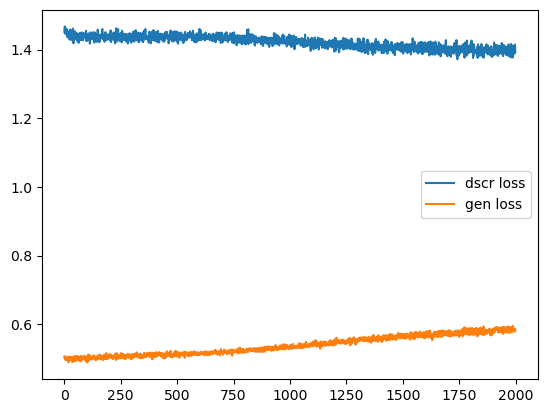

[ Info: Epoch 1: train step: 0, dscr loss: 1.448535534725099, gen loss: 0.46143267532402166
[ Info: Epoch 21: train step: 200, dscr loss: 1.4622852267771207, gen loss: 0.4739788895134924
[ Info: Epoch 41: train step: 400, dscr loss: 1.4494622860851316, gen loss: 0.4902682276643451
[ Info: Epoch 61: train step: 600, dscr loss: 1.413105636927432, gen loss: 0.5100107291877951
[ Info: Epoch 81: train step: 800, dscr loss: 1.4139735556033144, gen loss: 0.5223138671460611
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4209463060584453, gen loss: 0.527177104254103
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4237540681971983, gen loss: 0.5300688108058423
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4243501059999124, gen loss: 0.5301587319301364
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4206921408811821, gen loss: 0.5349908665373218
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4186645848510975, gen loss: 0.5538256155394766


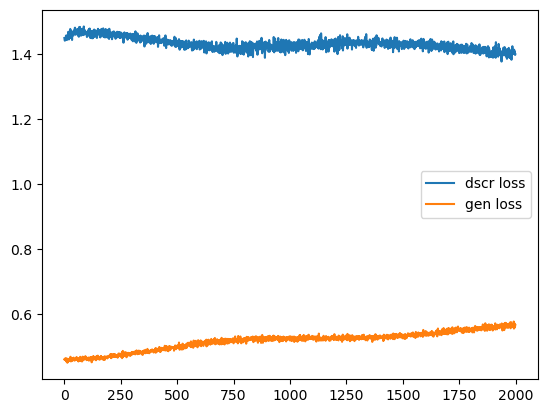

[ Info: Epoch 1: train step: 0, dscr loss: 1.4114202981826334, gen loss: 0.5125826604550296
[ Info: Epoch 21: train step: 200, dscr loss: 1.4090440708209877, gen loss: 0.5301322620400049
[ Info: Epoch 41: train step: 400, dscr loss: 1.4170105530677966, gen loss: 0.5286013284011948
[ Info: Epoch 61: train step: 600, dscr loss: 1.4187172084283692, gen loss: 0.5394645886524284
[ Info: Epoch 81: train step: 800, dscr loss: 1.4144525843542288, gen loss: 0.5360519831268519
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4311927986624273, gen loss: 0.5340510189146155
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4233678995973547, gen loss: 0.5368563138993591
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4448157327053175, gen loss: 0.5436768318055705
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4411311112756353, gen loss: 0.5568924587721239
[ Info: Epoch 181: train step: 1800, dscr loss: 1.42708375204727, gen loss: 0.5728120484864165


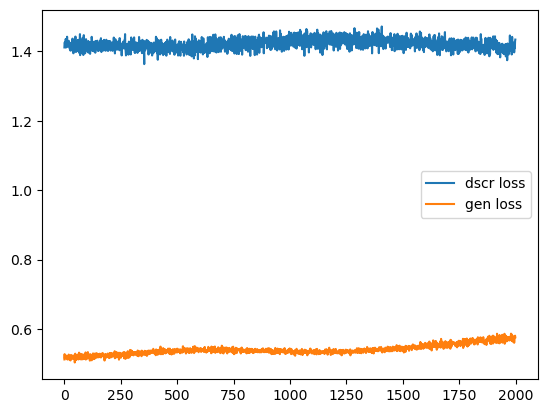

[ Info: Epoch 1: train step: 0, dscr loss: 1.4561390761696664, gen loss: 0.48472754716891614
[ Info: Epoch 21: train step: 200, dscr loss: 1.4465907602909638, gen loss: 0.48779420558728503
[ Info: Epoch 41: train step: 400, dscr loss: 1.4468497536570482, gen loss: 0.49572099103695166
[ Info: Epoch 61: train step: 600, dscr loss: 1.432266249664736, gen loss: 0.5021786681383523
[ Info: Epoch 81: train step: 800, dscr loss: 1.4305926208433883, gen loss: 0.5092136300062284
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4172745012221128, gen loss: 0.5213289119963117
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4176689013652832, gen loss: 0.5270933047206622
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4030324084873154, gen loss: 0.544870379781187
[ Info: Epoch 161: train step: 1600, dscr loss: 1.3950621663422291, gen loss: 0.5482621308949611
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4029990677476598, gen loss: 0.5631627895958764


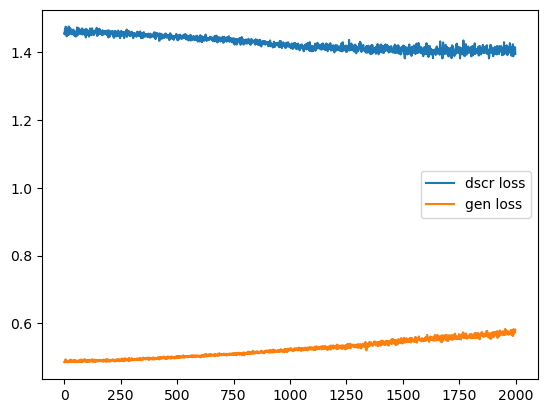

[ Info: Epoch 1: train step: 0, dscr loss: 1.436946758849776, gen loss: 0.4780821855373806
[ Info: Epoch 21: train step: 200, dscr loss: 1.4479443332655055, gen loss: 0.4737308613947767
[ Info: Epoch 41: train step: 400, dscr loss: 1.4406131357076983, gen loss: 0.4850176002721625
[ Info: Epoch 61: train step: 600, dscr loss: 1.431552918816027, gen loss: 0.494085365367865
[ Info: Epoch 81: train step: 800, dscr loss: 1.4339662680787844, gen loss: 0.50345412185298
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4355649285650802, gen loss: 0.5068464378243559
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4270317486417712, gen loss: 0.5131760810118751
[ Info: Epoch 141: train step: 1400, dscr loss: 1.427672477030781, gen loss: 0.5216942249966378
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4134118058548606, gen loss: 0.5264087797136644
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4214239316508062, gen loss: 0.5472064626963374


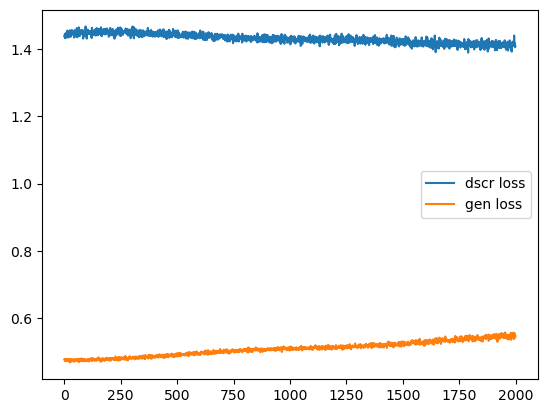

[ Info: Epoch 1: train step: 0, dscr loss: 1.491567471866098, gen loss: 0.4871946480267729
[ Info: Epoch 21: train step: 200, dscr loss: 1.4076141106638296, gen loss: 0.5123596990104431
[ Info: Epoch 41: train step: 400, dscr loss: 1.4008188255270344, gen loss: 0.5265101529515508
[ Info: Epoch 61: train step: 600, dscr loss: 1.416172405800344, gen loss: 0.530399906252492
[ Info: Epoch 81: train step: 800, dscr loss: 1.4403271782960938, gen loss: 0.518255760046286
[ Info: Epoch 101: train step: 1000, dscr loss: 1.4146199120604983, gen loss: 0.5211341757032593
[ Info: Epoch 121: train step: 1200, dscr loss: 1.4342649442747952, gen loss: 0.531879999224046
[ Info: Epoch 141: train step: 1400, dscr loss: 1.4213888325852353, gen loss: 0.52439121583741
[ Info: Epoch 161: train step: 1600, dscr loss: 1.4247364730661978, gen loss: 0.5349307475274374
[ Info: Epoch 181: train step: 1800, dscr loss: 1.4365720661753318, gen loss: 0.5296514487220019


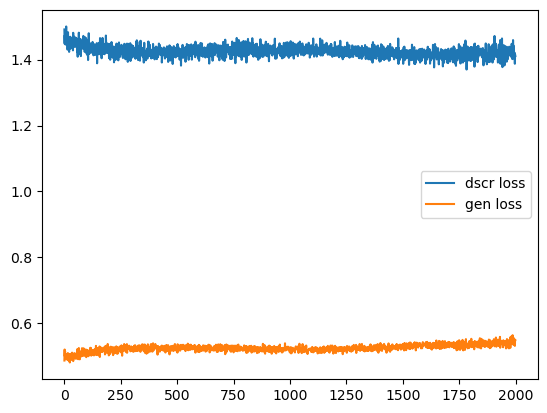

110.255767 seconds (422.81 M allocations: 70.300 GiB, 5.81% gc time, 33.04% compilation time)


In [25]:
hp = HyperParams()

gen_tot  = [generator(hp.latent_dim) for t in 1:TVALS]
dscr_tot = [discriminator() for t in 1:TVALS] 
@time begin
    for t in 1:TVALS
        train!(rr_re_images_train[t][:,:,1:1,:], dscr_tot[t], gen_tot[t], hp)    
    end
end


In [26]:
#all(isapprox.(dscr(rr_re_images[1][:,:,:,:]), 1, atol=0.1)) # dscr correctly classify input data as real data
#dscr_tot[1](rr_re_images[1][:,:,:,:]); # dscr correctly classify input data as real data
#generate_fake_sample(gen_tot[1], hp)
rr_re_images_train[1];

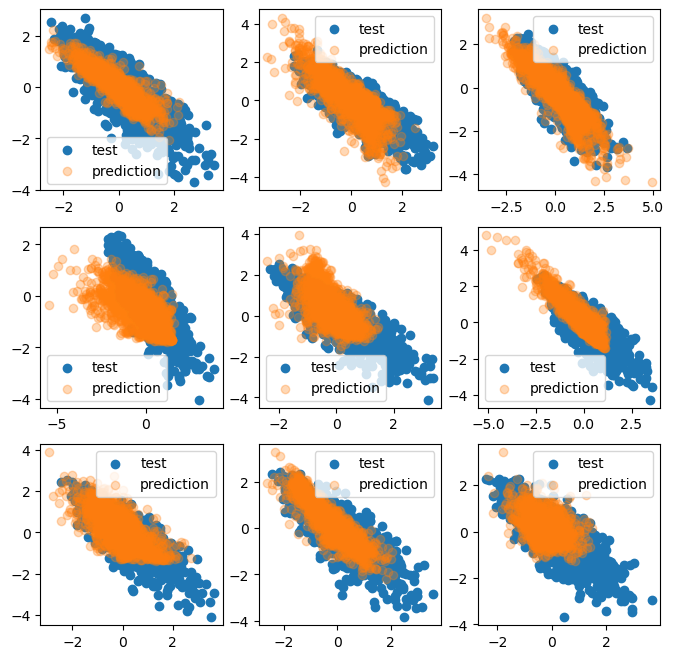

In [31]:

fig = figure(figsize=(8,8))
for k in 1:9
    
    t = k + 20
    ii = 330 + k
    fake_sample = generate_fake_sample(gen_tot[t], HyperParams(batch_size=2000))

    subplot(ii)
    scatter(normalise(rr_re_images_test[t][1, 1, 1:1, :]), normalise(rr_re_images_test[t][2, 1, 1:1, :]), label="test")
    scatter(fake_sample[1,:], fake_sample[2, :], label="prediction", alpha=0.3)
    legend()
end
#savefig(joinpath(path_plot, "GAN_prediction.pdf"))
display(gcf())
close("all")

In [32]:
fake_sample = generate_fake_sample(gen_tot[1], HyperParams(batch_size=2000))

2×2000 Matrix{Float64}:
 -0.212007  0.130542  0.55845   0.106398  …  -0.706229  -0.192357   -0.77715
  0.106277  0.328105  0.506483  0.355643     -0.568302  -0.0566472  -0.594139

In [44]:
rr_predicted = Array{Float64}(undef, TVALS, 2000, 1)
re_predicted = Array{Float64}(undef, TVALS, 2000, 1)

for t in 1:TVALS
    for ts in 1:1
        
        fake_sample = generate_fake_sample(gen_tot[1], HyperParams(batch_size=2000))
        rr_predicted[t,:,ts] = fake_sample[1,:] .* std_val[t,ts,1] .+ mean_val[t,ts,1]        
        re_predicted[t,:,ts] = fake_sample[2,:] .* std_val[t,ts,2] .+ mean_val[t,ts,2]
    end
end

In [ ]:
re_predicted;


In [45]:
corr_re_predicted = corr_obs_rr(re_predicted, "re_pred1");

tvals: 48
ncnfg: 2000
nsrcs: 1
(48, 2000)


In [46]:
corr_rr_predicted = corr_obs_rr(rr_predicted, "rr_pred1");

tvals: 48
ncnfg: 2000
nsrcs: 1
(48, 2000)


In [58]:
rr_true = permutedims(hcat(rr_re_images_test...)[1,:,:,:], (1,3,2)) 
re_true = permutedims(hcat(rr_re_images_test...)[2,:,:,:], (1,3,2)) 

rr_true_bc = permutedims(hcat(rr_re_images_train...)[1,:,:,:], (1,3,2)) 
re_true_bc = permutedims(hcat(rr_re_images_train...)[2,:,:,:], (1,3,2)) 

for t in 1:TVALS
    for ts in 1:4
        rr_true_bc[t,:,ts] = rr_true_bc[t,:,ts] .* std_val[t,ts,1] .+ mean_val[t,ts,1]
        re_true_bc[t,:,ts] = re_true_bc[t,:,ts] .* std_val[t,ts,2] .+ mean_val[t,ts,2]
    end
end

In [ ]:
re_true

In [48]:
corr_re_true = corr_obs_rr(re_true, "re_true");

tvals: 48
ncnfg: 2000
nsrcs: 4
(48, 2000)


In [49]:
corr_rr_true = corr_obs_rr(rr_true, "rr_true");

tvals: 48
ncnfg: 2000
nsrcs: 4
(48, 2000)


## Prediction and bias correction of rest-rest contribution

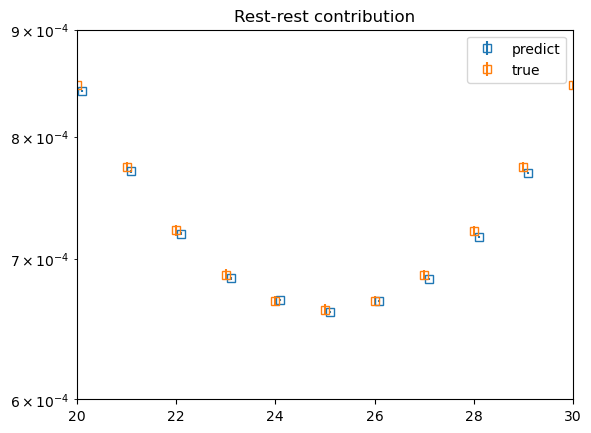

In [59]:
using ADerrors
uwerr.(corr_rr_predicted)
uwerr.(corr_rr_true)
xx = collect(1:length(corr_rr_true))
errorbar(xx.+0.1, value.(corr_rr_predicted), err.(corr_rr_predicted), fmt="s", label="predict", mfc="none")
errorbar(xx, value.(corr_rr_true), err.(corr_rr_true), fmt="s", label="true", mfc="none")
legend()
title("Rest-rest contribution")
xlim(20,30)
ylim(0.0006,0.0009)
yscale("log")
display(gcf())
close("all")

tvals: 48
ncnfg: 500
nsrcs: 4
(48, 500)


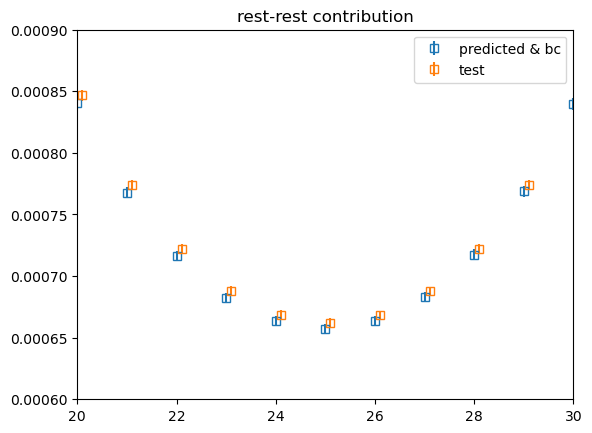

In [74]:
corr_rr_true_bc = corr_obs_rr(rr_true_bc[:,:,:], "rr_true_bc")
bc = corr_rr_true_bc .- corr_rr_predicted

corr_rr_pred_bc = corr_rr_predicted .+ bc

uwerr.(corr_rr_pred_bc)
uwerr.(corr_rr_true)
xx = collect(1:length(corr_rr_pred_bc))

errorbar(xx, value.(corr_rr_pred_bc), err.(corr_rr_pred_bc), fmt="s", label="predicted & bc", mfc="none")
errorbar(xx.+0.1, value.(corr_rr_true), err.(corr_rr_true), fmt="s", label="test", mfc="none")
xlim(20,30)
ylim(0.0006,0.0009)
title("rest-rest contribution")
legend()
#savefig("/Users/alessandroconigli/Desktop/re_prediction_bc.pdf")
display(gcf())
close("all")

## Prediction and bias correction of rest-eigen contribution

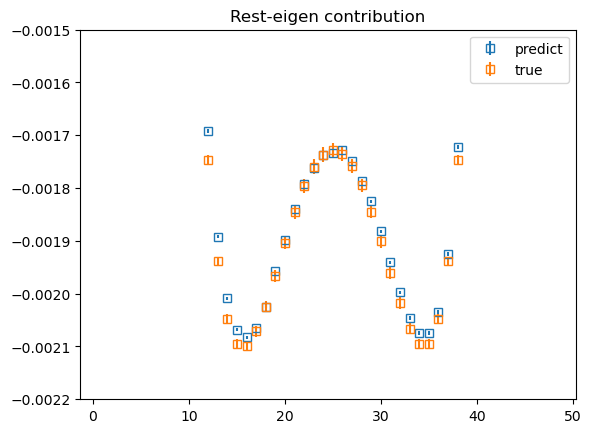

In [75]:
using ADerrors
uwerr.(corr_re_predicted)
uwerr.(corr_re_true)
xx = collect(1:length(corr_re_true))
errorbar(xx, value.(corr_re_predicted), err.(corr_re_predicted), fmt="s", label="predict", mfc="none")
errorbar(xx, value.(corr_re_true), err.(corr_re_true), fmt="s", label="true", mfc="none")
legend()
title("Rest-eigen contribution")
#xlim(5,10)
ylim(-0.0022,-0.0015)
#yscale("log")
display(gcf())
close("all")

tvals: 48
ncnfg: 500
nsrcs: 4
(48, 500)


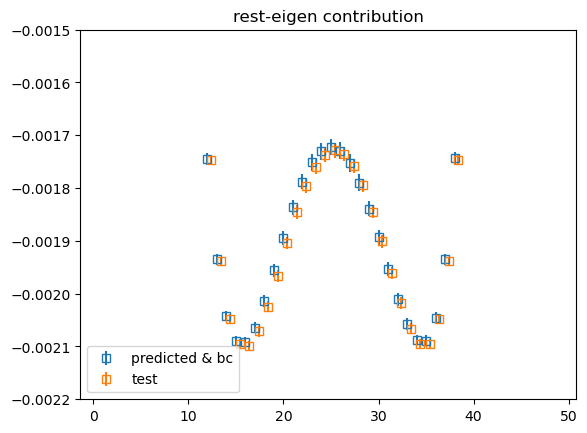

In [76]:
corr_re_true_bc = corr_obs_rr(re_true_bc, "re_true_bc")
bc = corr_re_true_bc .- corr_re_predicted


corr_re_pred_bc = corr_re_predicted .+ bc

uwerr.(corr_re_pred_bc)
uwerr.(corr_re_true)
xx = collect(1:length(corr_re_pred_bc))

errorbar(xx, value.(corr_re_pred_bc), err.(corr_re_pred_bc), fmt="s", label="predicted & bc", mfc="none")
errorbar(xx.+0.4, value.(corr_re_true), err.(corr_re_true), fmt="s", label="test", mfc="none")
# xlim(20,30)
ylim(-0.0022,-0.0015)
title("rest-eigen contribution")
legend()
#savefig("/Users/alessandroconigli/Desktop/re_prediction_bc.pdf")
display(gcf())
close("all")

In [66]:
println(corr_re_pred_bc[10])
println(corr_re_true[10])

-0.0010385192041128266 +/- 1.4216912811700712e-5
-0.0010342860473737045 +/- 1.1994650291453704e-5
